# Project 2: Topic Classification

In this project, you'll work with text data from newsgroup postings on a variety of topics. You'll train classifiers to distinguish between the topics based on the text of the posts. Whereas with digit classification, the input is relatively dense: a 28x28 matrix of pixels, many of which are non-zero, here we'll represent each document with a "bag-of-words" model. As you'll see, this makes the feature representation quite sparse -- only a few words of the total vocabulary are active in any given document. The bag-of-words assumption here is that the label depends only on the words; their order is not important.

The SK-learn documentation on feature extraction will prove useful:
http://scikit-learn.org/stable/modules/feature_extraction.html

Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

Load the data, stripping out metadata so that we learn classifiers that only use textual features. By default, newsgroups data is split into train and test sets. We further split the test so we have a dev set. Note that we specify 4 categories to use for this project. If you remove the categories argument from the fetch function, you'll get all 20 categories.

In [2]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test',
                                     remove=('headers', 'footers', 'quotes'),
                                     categories=categories)

num_test = len(newsgroups_test.target)
test_data, test_labels = newsgroups_test.data[int(num_test/2):], newsgroups_test.target[int(num_test/2):]
dev_data, dev_labels = newsgroups_test.data[:int(num_test/2)], newsgroups_test.target[:int(num_test/2)]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print('training label shape:', train_labels.shape)
print('test label shape:', test_labels.shape)
print('dev label shape:', dev_labels.shape)

print('labels names:', newsgroups_train.target_names)

training label shape: (2034,)
test label shape: (677,)
dev label shape: (676,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


**(1)**  
For each of the first 5 training examples, print the text of the message along with the label.

[2 pts]

In [3]:
def P1(num_examples=5):
### STUDENT START ###
    for msg in range(0, num_examples):
        label = train_labels[msg]
        label_text = newsgroups_train.target_names[label]
        print(f"\n\u001b[1m**\n Message Number {msg+1} which has label {label}: {label_text}\n**\u001b[0m\n")
        print(train_data[msg])

### STUDENT END ###
P1(5)


**
 Message Number 1 which has label 1: comp.graphics
**

Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych

**
 Message Number 2 which has label 3: talk.religion.misc
**



Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcakes like Kores

**(2)**  
Use CountVectorizer to turn the raw training text into feature vectors. You should use the fit_transform function, which makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").

The vectorizer has a lot of options. To get familiar with some of them, write code to answer these questions:

**a.** The output of the transform (also of fit_transform) is a sparse matrix: http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html. What is the size of the vocabulary? What is the average number of non-zero features per example? What fraction of the entries in the matrix are non-zero? Hint: use "nnz" and "shape" attributes.

**b.** What are the 0th and last feature strings (in alphabetical order)? Hint: use the vectorizer's get_feature_names function.

**c.** Specify your own vocabulary with 4 words: ["atheism", "graphics", "space", "religion"]. Confirm the training vectors are appropriately shaped. Now what's the average number of non-zero features per example?

**d.** Instead of extracting unigram word features, use "analyzer" and "ngram_range" to extract bigram and trigram character features. What size vocabulary does this yield?

**e.** Use the "min_df" argument to prune words that appear in fewer than 10 documents. What size vocabulary does this yield?

**f.** Using the standard CountVectorizer, what fraction of the words in the dev data are missing from the vocabulary? Hint: build a vocabulary for both train and dev and look at the size of the difference.

[6 pts]

In [4]:
def P2():
### STUDENT START ###
    '''This function answers problem 2, doing some basic manipulation and EDA on the messages using CountVectorizer.
    Each message is an "example", or "row" in the vectorized sparse matrix. 
    Each word is a "feature" or "column" in the vectorized sparse matrix.
    Entries in the array represent the frequency for a given word in the given example.
    '''
    # (a)
    # Instantiate, fit and transform the messages to vectors, creating the vocabulary (feature list) along the way
    vectorizer = CountVectorizer()
    vectors = vectorizer.fit_transform(train_data)
    vocab = vectorizer.vocabulary_  # Obtain the vocabulary
    
    # num_features is the number of unique words >= 2 letters (could also be done with .get_feature_names)
    num_features = len(vocab)
    print("\u001b[1m(a)\u001b[0m\nSize of Vocabulary = ",num_features)
    
    # sum across rows and take the average to find average number of words in each message
    avg_per_example = np.mean(vectors.getnnz(1))
    print(f"Average Non-zero features (i.e. unique words) per example: {avg_per_example:.5}")
    
    # Calculate matrix size, and use the number of non-zero entries in the sparse matrix to find the fraction of non zero entries.
    total_entries = vectors.get_shape()[0]*vectors.get_shape()[1]
    density1 = vectors.nnz/total_entries
    print(f"Fraction Non Zero entries in Training Matrix (density) = {density1:.4} - a very sparse matrix")
    
    # (b)
    # Select first and last feature names and print alphabetically
    first_last = [vectorizer.get_feature_names()[0],vectorizer.get_feature_names()[-1]]
    print("\n\u001b[1m(b)\u001b[0m\nFirst (0th) and Last Feature strings, sorted alphabetically: ",sorted(first_last))
    
    # (c)
    # fit and transform the data using a specified vocabulary of only 4 words - in order to count the occurence of those words
    vectorizer2 = CountVectorizer(vocabulary= ["atheism", "graphics", "space", "religion"]) # specify the vocabulary to be used
    vectors2=vectorizer2.fit_transform(train_data)
    
    # print the shapes from the original fit_transform and current to ensure we got it right
    print("\n\u001b[1m(c)\u001b[0m\nOriginal vector matrix shape:", vectors.get_shape())
    print('Specified Vocabulary ["atheism", "graphics", "space", "religion"] vector matrix shape:', vectors2.get_shape())
    print(f"New Training Vectors Shape Confirmed correct, "
          f"with {vectors2.get_shape()[1]} features and {vectors2.get_shape()[0]} examples")
    
    # Calculate the average non-zero words per example (same process as in (a))
    avg_per_example2 = np.mean(vectors2.getnnz(1))
    print(f"Average Non-zero features per example with new 4 word vocabulary: {avg_per_example2:.5}")
    print("This means that on average, every message has approximately one of the 4 word vocabulary words")
    total_entries2 = vectors2.get_shape()[0]*vectors2.get_shape()[1]
    density2 = vectors2.nnz / total_entries2
    print(f"Vectorized fraction non zero with new Vocabulary = {density2:.4} - "
          f"a factor of {(density2/density1):.3} more dense than previous")
    
    # (d)
    # Re-specify the vectorizer to include only 2 and 3 word combinations, then determine new vocabulary size
    vectorizer3 = CountVectorizer(ngram_range=(2,3),analyzer='word')
    vectors3 = vectorizer3.fit_transform(train_data)
    vocab3 = vectorizer3.vocabulary_
    print(f"\n\u001b[1m(d)\u001b[0m\nConsidering only 2 and 3 word n-grams, the vocabulary size is now {len(vocab3)} words.")
    print(f"New Vocabulary is {len(vocab3)/len(vocab):.3} times larger than original.")
    print(f"Average Non-zero features per example for bi- and tri- grams is {(np.mean(vectors3.getnnz(1))):.5}")
    
    # (e)
    # Specify vectorizer such that words must occur in at least 10 documents (minimum document frequency=10)
    # Compare size of resulting vocabulary
    vectorizer4 = CountVectorizer(min_df=10)
    vectors4 = vectorizer4.fit_transform(train_data)
    vocab4 = vectorizer4.vocabulary_
    print(f"\n\u001b[1m(e)\u001b[0m\nConsidering only words that occur in at least 10 documents,"
          f" the vocabulary size becomes {len(vocab4)} words.")
    print(f"New Vocabulary is {len(vocab4)/len(vocab):.3} fraction of original vocabulary size.")
    print(f"Average Non-zero features per example when words must appear in "
          f"at least 10 documents is {(np.mean(vectors4.getnnz(1))):.5}")
    
    # (f)
    # Determine what fraction of words in Dev Data are not in Train Data by looking at feature_name sizes
    vectorizer_dev = CountVectorizer() # Using defaults for CountVectorizer
    vectors_dev = vectorizer_dev.fit_transform(dev_data) # Fit and transform
    
    # Define the lists for each group of feature names for simplicity
    dev_feats = vectorizer_dev.get_feature_names() 
    train_feats = vectorizer.get_feature_names()
    
    # Change feature name lists to sets to enable subtraction, which identifies words in dev that are not in train
    words_in_dev_only = set(dev_feats)-set(train_feats)

    # Print Results, calculating fraction of dev words not in the training vocabulary
    print(f"\n\u001b[1m(f)\u001b[0m\nUsing the Standard CountVectorizer, \nTraining vocabulary has {len(train_feats)} words")
    print(f"Dev vocabulary has {len(dev_feats)} words")
    print(f"{len(words_in_dev_only)} words are in dev that are not in training")
    print(f"Words in dev that are not in train as fraction of dev data vocabulary size: "
          f" {(len(words_in_dev_only)/len(dev_feats)):.3}\n"
          f"This is a quarter of the words in the dev set, which may result in an increased amount of misidentifications later")
    
    
### STUDENT END ###
P2()

(a)
Size of Vocabulary =  26879
Average Non-zero features (i.e. unique words) per example: 96.706
Fraction Non Zero entries in Training Matrix (density) = 0.003598 - a very sparse matrix

(b)
First (0th) and Last Feature strings, sorted alphabetically:  ['00', 'zyxel']

(c)
Original vector matrix shape: (2034, 26879)
Specified Vocabulary ["atheism", "graphics", "space", "religion"] vector matrix shape: (2034, 4)
New Training Vectors Shape Confirmed correct, with 4 features and 2034 examples
Average Non-zero features per example with new 4 word vocabulary: 0.26844
This means that on average, every message has approximately one of the 4 word vocabulary words
Vectorized fraction non zero with new Vocabulary = 0.06711 - a factor of 18.7 more dense than previous

(d)
Considering only 2 and 3 word n-grams, the vocabulary size is now 510583 words.
New Vocabulary is 19.0 times larger than original.
Average Non-zero features per example for bi- and tri- grams is 342.02

(e)
Considering only wor

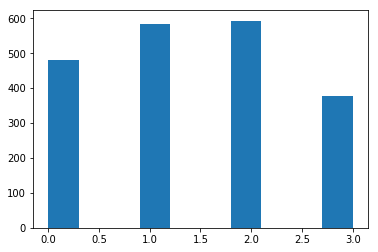

In [10]:
# Histogram to understand distribution of message labels
plt.hist(train_labels)
plt.show()

-----

**(3)**  
Use the default CountVectorizer options and report the f1 score (use metrics.f1_score) for a k nearest neighbors classifier; find the optimal value for k. Also fit a Multinomial Naive Bayes model and find the optimal value for alpha. Finally, fit a logistic regression model and find the optimal value for the regularization strength C using l2 regularization. A few questions:

**a.** Why doesn't nearest neighbors work well for this problem?

**b.** Any ideas why logistic regression doesn't work as well as Naive Bayes?

**c.** Logistic regression estimates a weight vector for each class, which you can access with the coef\_ attribute. Output the sum of the squared weight values for each class for each setting of the C parameter. Briefly explain the relationship between the sum and the value of C.

[4 pts]

kNN model, Euclidean Distance, Grid Search optimization for k (no. of nearest neighbours)


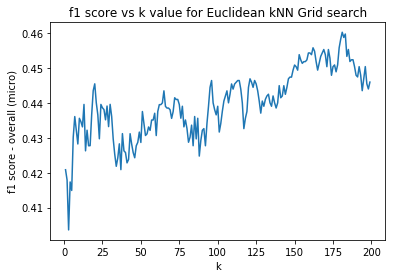

Best k value = 181 with f1 = 0.4602

Multinomial naive Bayes, Grid Search optimization for alpha (Laplace Smoothing)


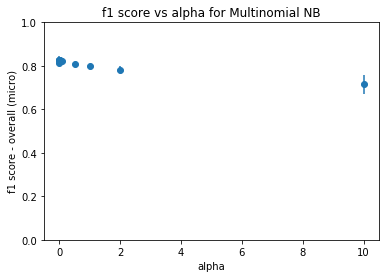

Best Alpha value = 0.01 with f1 = 0.8284

Logistic Regression, Optimization for C (I2 Regularlization Strength)


In [67]:
#def P3():
### STUDENT START ###


# def fit_score_knn(k,train_data,train_labels,dev_data,dev_labels):
#     '''Train kNN model on train_data, score fit against dev_data; use default kNN Euclidean distance (p=2)
#     return f1 Score
#     '''
#     model = KNeighborsClassifier(n_neighbors=k)
#     model.fit(train_data,train_labels)
#     pred_labels = model.predict(dev_data)
#     return metrics.f1_score(dev_labels,pred_labels,average='micro')

# def kopt(kupper, train_data, train_labels, dev_data, dev_labels):
#     '''Run kNN model on k values from 1 to kupper on train data
#     Plot k vs. f1 score - determining f1 score on dev_data.
#     Return value of k, kmax, for maximum f1 score
#     '''
#     krange = np.arange(1,kupper)
#     f1scores = []
#     for k in krange:
#         knn_score = fit_score_knn(k,train_data,train_labels,dev_data,dev_labels)
#         f1scores.append(knn_score)
#     plt.plot(krange,f1scores)
#     plt.xlabel("k")
#     plt.ylabel("f1 score - overall (micro)")
#     plt.title("f1 score vs k value for Euclidean kNN")
#     plt.show()
#     kmax = np.argmax(f1scores) + 1   # Add 1 because k starts at 1 but index of array starts at 0
#     f1max = f1scores[kmax-1]
#     return (kmax, f1max)

def kopt2(kupper, train_data, train_labels, dev_data, dev_labels):
    '''Train and predict using a kNN model (Euclidean distance) on k values from 1 to kupper on train data
    Using GridSearch to find k vs f1 score
    '''
    # Define Classifier
    knn_clf = KNeighborsClassifier()
    
    # Define ks and Grid search
    krange = np.arange(1,kupper)
    kvals = {'n_neighbors':krange}
    clf = GridSearchCV(knn_clf,kvals,scoring='f1_micro',cv=5,iid=False)
    results = clf.fit(train_data,train_labels).cv_results_
    ks = results['param_n_neighbors']
    means = results['mean_test_score']
    ranks = results['rank_test_score']
    
    # Print graph
    plt.plot(ks,means)
    plt.xlabel("k")
    plt.ylabel("f1 score - overall (micro)")
    plt.title("f1 score vs k value for Euclidean kNN Grid search")
    plt.show()
    
    return (ranks,ks,means)

def mnb(train_data,train_labels,dev_data,dev_labels):
    '''Train and predict using a multinomial naive bayes model and GridSearch 
    to find alpha (Laplace smoothing parameter) vs f1 score
    '''
    # Define classifier
    mnb_clf = MultinomialNB()
    
    # Define alphas and GridSearch
    alphas = {'alpha': [1.0e-10, 0.00001, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
    clf = GridSearchCV(mnb_clf,alphas,scoring='f1_micro',cv=5,iid=False)
    results = clf.fit(train_data,train_labels).cv_results_
    alfs = results['param_alpha']
    means = results['mean_test_score']
    stdevs = results['std_test_score']
    ranks = results['rank_test_score']
    
    # Print graph
    plt.errorbar(alfs,means,yerr=stdevs,fmt='o')
    plt.ylim(0,1)
    plt.xlabel('alpha')
    plt.ylabel('f1 score - overall (micro)')
    plt.title('f1 score vs alpha for Multinomial NB')
    plt.show()
    
    return(ranks,alfs,means)


def P3():
    '''Comparison of classification models for identification of group that messages belong to
    1) Create new_train_data using CountVectorizer defaults on the train_data set
    2) Fit a kNN model, and optimize for k, reporting f1 score
    3) Fit a Multinomial NB model and optimize for alpha
    4) Fit a logistic regression model and find optimum regularization strength C using I2 regularization
    '''
    
    # Vectorize train and dev messages. - USE transform from TRAIN on DEV data to ensure using same vocabulary (# of features)
    vectorizer = CountVectorizer()
    new_train_data = vectorizer.fit_transform(train_data)
    new_dev_data = vectorizer.transform(dev_data)
    
    # kNN Model
    # Note that in testing, I ran this up to k=1000 and determined that for k>200, the f1 continues to drop
    # So, I set maximum k for this assignment at 200 to minimize run time
    print("\u001b[1mkNN model, Euclidean Distance, Grid Search optimization for k (no. of nearest neighbours)\u001b[0m")
    kupper=200 # Best k is 181, f1=0.4602 SET TO 200 Before submitting
    kranks,ks,kmeans = kopt2(kupper,new_train_data,train_labels,new_dev_data,dev_labels)
    bestk_idx = np.where(kranks==1)[0][0]
    print(f"Best k value = {ks[bestk_idx]} with f1 = {kmeans[bestk_idx]:.4}")
        
    # Multinomial Naive Bayes Model
    print(f"\n\u001b[1mMultinomial naive Bayes, Grid Search optimization for alpha (Laplace Smoothing)\u001b[0m")
    ranks,alfs,means = mnb(new_train_data,train_labels,new_dev_data,dev_labels)
    best_idx = np.where(ranks==1)[0][0]
    print(f"Best Alpha value = {alfs[best_idx]} with f1 = {means[best_idx]:.4}")
    
    # Logistic Regression Model
    print(f"\n\u001b[1mLogistic Regression, Optimization for C (I2 Regularlization Strength)\u001b[0m")
    
        
### STUDENT END ###
P3()

ANSWER:

(4) Train a logistic regression model. Find the 5 features with the largest weights for each label -- 20 features in total. Create a table with 20 rows and 4 columns that shows the weight for each of these features for each of the labels. Create the table again with bigram features. Any surprising features in this table?

[5 pts]

In [ ]:
#def P4():
### STUDENT START ###


### STUDENT END ###
#P4()

ANSWER:

(5) Try to improve the logistic regression classifier by passing a custom preprocessor to CountVectorizer. The preprocessing function runs on the raw text, before it is split into words by the tokenizer. Your preprocessor should try to normalize the input in various ways to improve generalization. For example, try lowercasing everything, replacing sequences of numbers with a single token, removing various other non-letter characters, and shortening long words. If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular. With your new preprocessor, how much did you reduce the size of the dictionary?

For reference, I was able to improve dev F1 by 2 points.

[4 pts]

In [ ]:
def empty_preprocessor(s):
    return s

#def better_preprocessor(s):
### STUDENT START ###

### STUDENT END ###

#def P5():
### STUDENT START ###

    
### STUDENT END ###
#P5()

(6) The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. That is, logistic regression seeks the set of weights that minimizes errors in the training data AND has a small size. The default regularization, L2, computes this size as the sum of the squared weights (see P3, above). L1 regularization computes this size as the sum of the absolute values of the weights. The result is that whereas L2 regularization makes all the weights relatively small, L1 regularization drives lots of the weights to 0, effectively removing unimportant features.

Train a logistic regression model using a "l1" penalty. Output the number of learned weights that are not equal to zero. How does this compare to the number of non-zero weights you get with "l2"? Now, reduce the size of the vocabulary by keeping only those features that have at least one non-zero weight and retrain a model using "l2".

Make a plot showing accuracy of the re-trained model vs. the vocabulary size you get when pruning unused features by adjusting the C parameter.

Note: The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.01 (the default is .0001).

[4 pts]

In [ ]:
def P6():
    # Keep this random seed here to make comparison easier.
    np.random.seed(0)

    ### STUDENT START ###

    

    ### STUDENT END ###
P6()

(7) Use the TfidfVectorizer -- how is this different from the CountVectorizer? Train a logistic regression model with C=100.

Make predictions on the dev data and show the top 3 documents where the ratio R is largest, where R is:

maximum predicted probability / predicted probability of the correct label

What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

[4 pts]

In [ ]:
#def P7():
    ### STUDENT START ###



    ### STUDENT END ###
#P7()

ANSWER:

(8) EXTRA CREDIT

Try implementing one of your ideas based on your error analysis. Use logistic regression as your underlying model.

- [1 pt] for a reasonable attempt
- [2 pts] for improved performance